# **Skenario 1 - CNN VGG16**

Skenario 1 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur VGG16 untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Impor semua pustaka dan modul yang dibutuhkan untuk pemrosesan data, visualisasi, pembuatan model, dan pelatihan model

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import pickle

# Scikit-learn imports
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import KFold

# TensorFlow and Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data

Load dan proses data `image_selected.npz`

In [2]:
def load_and_preprocess_data():
    base_dir = r"D:\Users\RESA\Coding\Alzheimer-Classification-with-CNN-SVM\Notebook\Preprocessing\image_selected.npz"
    
    # Load data from npz file
    loaded_data = np.load(base_dir, allow_pickle=True)
    loaded_combined_slices = loaded_data[list(loaded_data.keys())[0]]

    # Prepare X dan Y lists
    X = []
    Y = []

    # Buat label mapping untuk tiap kelas 
    label_mapping = {'AD': 0, 'CN': 1, 'EMCI': 2, 'LMCI': 3}

    # Iterate through loaded data
    for label, plane_slices in loaded_combined_slices.item().items():
        for plane, slices in plane_slices.items():
            for selected_slice in slices:
                position, resized_slice = selected_slice

                # Pastikan resized_slice memiliki tiga saluran warna
                resized_slice_rgb = cv2.cvtColor(resized_slice, cv2.COLOR_GRAY2RGB)
    
                # Append data to X and Y
                X.append(resized_slice_rgb)
                Y.append(label_mapping[label])

    # Convert lists ke numpy arrays
    X = np.array(X) / 255.0  # Normalisasi
    Y = np.array(Y)

    # Convert labels to categorical format
    Y = to_categorical(Y, num_classes=len(set(Y)))

    return X, Y

In [3]:
X, Y = load_and_preprocess_data()

In [4]:
print("X shape:", X.shape)
print("Y shape:", Y.shape)

X shape: (7200, 224, 224, 3)
Y shape: (7200, 4)


In [5]:
unique_labels, counts = np.unique(np.argmax(Y, axis=1), return_counts=True)
class_distribution = dict(zip(tuple(unique_labels), counts))

print("Distribusi Kelas setelah One-Hot Encoding:")
print(class_distribution)

Distribusi Kelas setelah One-Hot Encoding:
{0: 1800, 1: 1800, 2: 1800, 3: 1800}


### 2.2 Pembagian Data

In [6]:
# Bagi dataset
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
print("Dimensi X_train:", X_train.shape)
print("Dimensi Y_train:", Y_train.shape)
print("Dimensi X_test:", X_test.shape)
print("Dimensi Y_test:", Y_test.shape)

Dimensi X_train: (5760, 224, 224, 3)
Dimensi Y_train: (5760, 4)
Dimensi X_test: (1440, 224, 224, 3)
Dimensi Y_test: (1440, 4)


In [8]:
print("Jumlah sampel dalam X_train:", len(X_train))
print("Jumlah sampel dalam Y_train:", len(Y_train))
print("Jumlah sampel dalam X_test:", len(X_test))
print("Jumlah sampel dalam Y_test:", len(Y_test))

Jumlah sampel dalam X_train: 5760
Jumlah sampel dalam Y_train: 5760
Jumlah sampel dalam X_test: 1440
Jumlah sampel dalam Y_test: 1440


## 3. Buat dan Konfigurasi Model

Arsitektur yang digunakan yaitu VGG16 sebagai bagian dari transfer learning yaitu arsitektur yang sudah dilatih dengan data ImageNet

In [9]:
%%time
base_model = VGG16(
    weights='imagenet',
    input_shape=(224, 224, 3),
    include_top=False
)

base_model.trainable = False

# Membuat inputan layer
inputs = Input(shape=(224, 224, 3))

# Menggunakan base_model sebagai lapisan dalam model Anda
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(4, activation='sigmoid')(x)

# Menggabungkan input dan output untuk membuat model
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 4)                 2052      
Total params: 14,716,740
Trainable params: 2,052
Non-trainable params: 14,714,688
_________________________________________________________________
CPU times: total: 984 ms
Wall time: 949 ms


## 4. Training Model
Latih model dengan data `X_train dan Y_train` dan menguji kinerja model pada data validasi `X_test dan Y_test`, setelah pelatihan nanti model akan menyimpan riwayatnya ke dalam `h_model`

In [10]:
EPOCH = 25
BATCH_SIZE = 16
h_model = model.fit(X_train, Y_train, epochs=EPOCH, validation_data=(X_test, Y_test), batch_size=BATCH_SIZE)

Epoch 1/25
360/360 [==============================] - 523s 1s/step - loss: 1.4016 - accuracy: 0.2748 - val_loss: 1.3353 - val_accuracy: 0.3535
Epoch 2/25
360/360 [==============================] - 542s 2s/step - loss: 1.3102 - accuracy: 0.3865 - val_loss: 1.3125 - val_accuracy: 0.3875
Epoch 3/25
360/360 [==============================] - 533s 1s/step - loss: 1.2790 - accuracy: 0.4070 - val_loss: 1.3000 - val_accuracy: 0.3868
Epoch 4/25
360/360 [==============================] - 537s 1s/step - loss: 1.2634 - accuracy: 0.4281 - val_loss: 1.2751 - val_accuracy: 0.4347
Epoch 5/25
360/360 [==============================] - 549s 2s/step - loss: 1.2396 - accuracy: 0.4509 - val_loss: 1.2624 - val_accuracy: 0.4326
Epoch 6/25
360/360 [==============================] - 551s 2s/step - loss: 1.2195 - accuracy: 0.4761 - val_loss: 1.2480 - val_accuracy: 0.4354
Epoch 7/25
360/360 [==============================] - 547s 2s/step - loss: 1.1947 - accuracy: 0.4743 - val_loss: 1.2356 - val_accuracy: 0.4611

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test, Y_test, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(Y_test, axis=1))
print('Label Prediksi : ', predicted_labels)

45/45 [==============================] - 106s 2s/step - loss: 1.1313 - accuracy: 0.5229
Loss: 1.1312956809997559
Accuracy: 0.5229166746139526
Label Sebenarnya :  [1 1 2 ... 3 1 1]
Label Prediksi :  [0 1 1 ... 2 0 2]


### 5.2 Visualisasi beberapa gambar dari data uji
Membuat visualisasi dari beberapa contoh hasil prediksi model pada data test

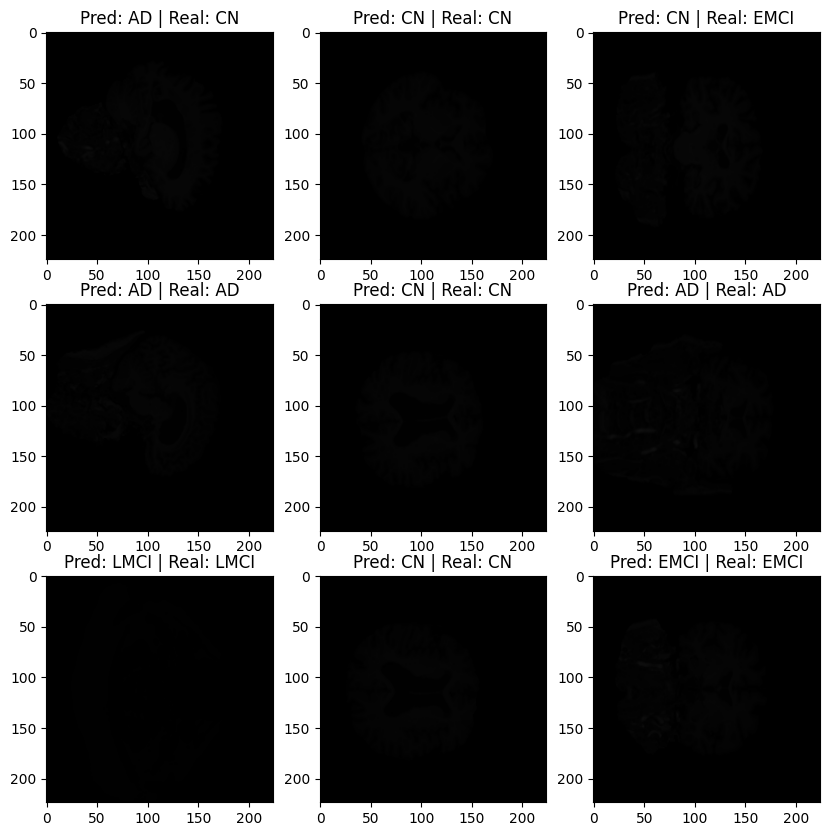

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[i].astype("uint8"))
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(Y_test[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

### 6.1 Matriks specificity dan sensitivity

In [13]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Matriks pada data train

In [14]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train, Y_train)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

180/180 [==============================] - 429s 2s/step - loss: 1.0451 - accuracy: 0.5894 - specificity: 0.8176 - sensitivity: 0.6349
Loss train set:  1.0457100868225098
Akurasi train set:  0.5859375
Specificity train set:  0.8163771033287048
Sensitivity train set:  0.6345486044883728


Matriks pada data test

In [15]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test, Y_test)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

45/45 [==============================] - 108s 2s/step - loss: 1.1313 - accuracy: 0.5229 - specificity: 0.8005 - sensitivity: 0.5597
Loss train set:  1.1312956809997559
Akurasi train set:  0.5229166746139526
Specificity train set:  0.8004630208015442
Sensitivity train set:  0.5597222447395325


### 6.2 Confusion Matrix dan Classification Report

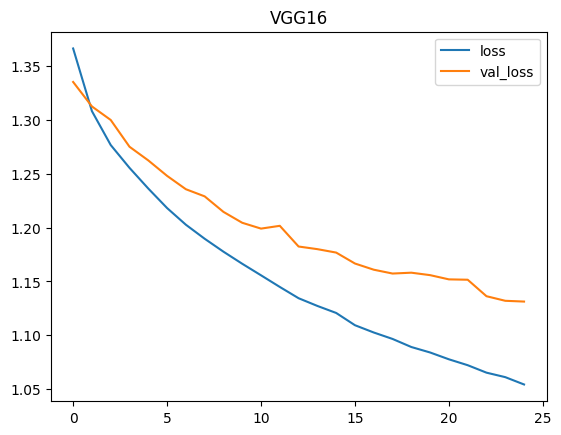

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# loss
fig, ax = plt.subplots()
ax.plot(h_model.history['loss'], label='loss')
ax.plot(h_model.history['val_loss'], label='val_loss')
ax.legend()
plt.title('VGG16')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\VGG16Loss.png')

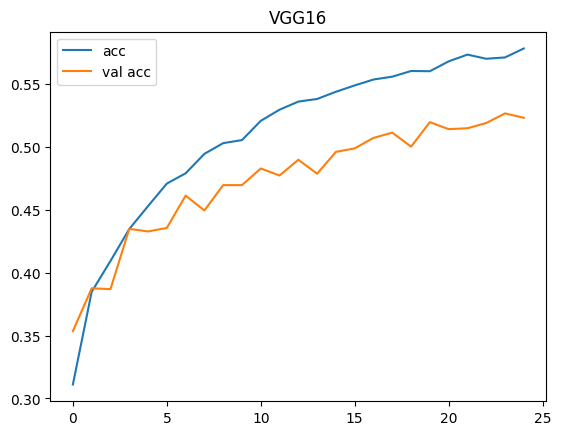

In [17]:
# accuracies
fig, ax = plt.subplots()
ax.plot(h_model.history['accuracy'], label='acc')
ax.plot(h_model.history['val_accuracy'], label='val acc')
ax.legend()
plt.title('VGG16')
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\VGG16Accuracy.png')

In [18]:
# Simpan model
model.save(r"D:\Users\RESA\Coding\Evaluasi\VGG16.h5")

In [19]:
# Prediksi model pd X_test
y_preds =  model.predict(X_test)
y_preds

array([[0.57132107, 0.37669998, 0.25914198, 0.31202066],
       [0.15964559, 0.59275323, 0.46297133, 0.5415799 ],
       [0.47908092, 0.53160834, 0.46424782, 0.30832112],
       ...,
       [0.4704331 , 0.4461982 , 0.51337546, 0.3059631 ],
       [0.51833326, 0.38369024, 0.25802612, 0.39088586],
       [0.32824713, 0.5167964 , 0.5989581 , 0.36699614]], dtype=float32)

In [20]:
# Ambil indeks nilai tertinggi dari tiap pred
y_preds_ind = np.argmax(y_preds,axis=1)
y_preds_ind

array([0, 1, 1, ..., 2, 0, 2], dtype=int64)

In [21]:
# Ambil indeks nilai maks dari tiap label sebenarnya
qwe=np.argmax(Y_test, axis=1)

In [22]:
confusion_matrix(qwe,y_preds_ind)

array([[203,  76,  58,  43],
       [ 41, 199,  66,  32],
       [ 51,  83, 205,  24],
       [ 60,  75,  78, 146]], dtype=int64)

In [23]:
print(classification_report(qwe,y_preds_ind))

              precision    recall  f1-score   support

           0       0.57      0.53      0.55       380
           1       0.46      0.59      0.52       338
           2       0.50      0.56      0.53       363
           3       0.60      0.41      0.48       359

    accuracy                           0.52      1440
   macro avg       0.53      0.52      0.52      1440
weighted avg       0.53      0.52      0.52      1440



In [24]:
model.evaluate(X_test, Y_test)

45/45 [==============================] - 107s 2s/step - loss: 1.1313 - accuracy: 0.5229 - specificity: 0.8005 - sensitivity: 0.5597


[1.1312956809997559,
 0.5229166746139526,
 0.8004630208015442,
 0.5597222447395325]

### 6.3 ROC AUC Curve

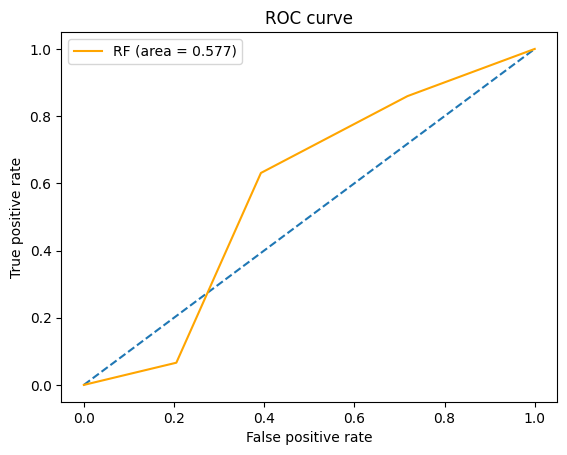

In [25]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve(qwe, y_preds_ind, pos_label=2)

auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.figure(1)
plt.plot([0, 1], [0, 1],"--")

plt.plot(fpr, tpr, label='RF (area = {:.3f})'.format(auc), color='orange')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Hasil visualisasinya

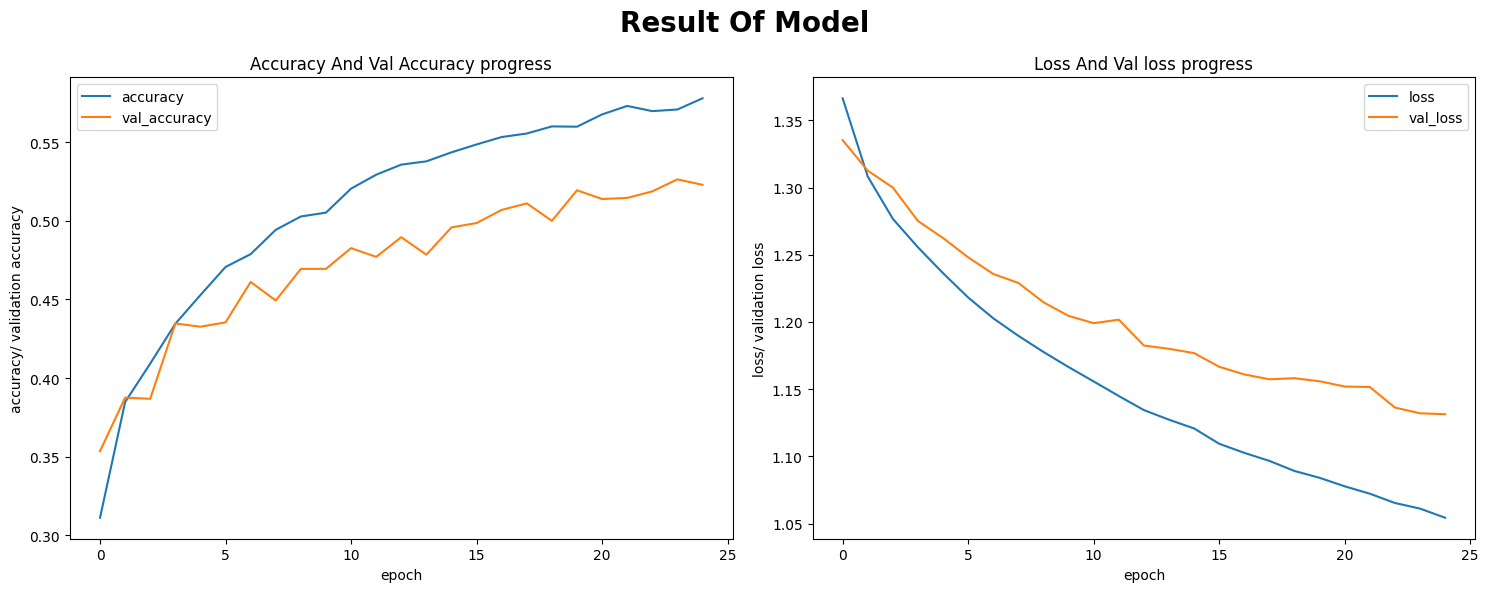

In [26]:
def Visualize_Result(acc,val_acc,loss, val_loss):
    fig, (ax1, ax2) = plt.subplots(nrows = 1,
                                   ncols = 2,
                                   figsize = (15,6))

    plot1 = ax1.plot(range(0, len(acc)),
                     acc,
                     label = 'accuracy')

    plot2 = ax1.plot(range(0, len(val_acc)),
                     val_acc,
                     label = 'val_accuracy')

    ax1.set(title = 'Accuracy And Val Accuracy progress',
            xlabel = 'epoch',
            ylabel = 'accuracy/ validation accuracy')

    ax1.legend()

    plot3 = ax2.plot(range(0, len(loss)),
                     loss,
                     label = 'loss')
    
    plot4 = ax2.plot(range(0, len(val_loss)),
                     val_loss,
                     label = 'val_loss')
    
    ax2.set(title = 'Loss And Val loss progress',
            xlabel = 'epoch',
            ylabel = 'loss/ validation loss')

    ax2.legend()

    fig.suptitle('Result Of Model', fontsize = 20, fontweight = 'bold')
    fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_Loss_figure_VGG16.png')
    plt.tight_layout()
    plt.show()

visualize_result = Visualize_Result(h_model.history['accuracy'],h_model.history['val_accuracy'], h_model.history['loss'], h_model.history['val_loss'])

## 7. Cross - Validation

In [27]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Set early stopping criteria
pat = 5 
early_stopping = EarlyStopping(monitor='val_loss', patience=pat, verbose=1)

# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint(r'D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5', verbose=1, save_best_only=True)

# Define a function to fit the model
def fit_and_evaluate(X_train, X_test, Y_train, Y_test, EPOCHS=20, BATCH_SIZE=16, model=model):
    results = model.fit(X_train, Y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                        callbacks=[early_stopping, model_checkpoint], verbose=1, validation_split=0.2)
    print("Val Score: ", model.evaluate(X_test, Y_test))
    return results

### 7.1 Training

In [28]:
n_folds = 5
epochs = 20
batch_size = 16

# Save the model history
model_history = []

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2,
                                                        random_state=np.random.randint(1, 1000, 1)[0])
    
    model_history.append(fit_and_evaluate(X_train, X_test, Y_train, Y_test, epochs, batch_size))
    
    # Manual garbage collection
    gc.collect()
    
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/20
288/288 [==============================] - 438s 2s/step - loss: 1.0669 - accuracy: 0.5662 - specificity: 0.8398 - sensitivity: 0.5883 - val_loss: 1.0723 - val_accuracy: 0.5469 - val_specificity: 0.8290 - val_sensitivity: 0.5651

Epoch 00001: val_loss improved from inf to 1.07234, saving model to D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5
Epoch 2/20
288/288 [==============================] - 438s 2s/step - loss: 1.0599 - accuracy: 0.5734 - specificity: 0.8450 - sensitivity: 0.5807 - val_loss: 1.0667 - val_accuracy: 0.5530 - val_specificity: 0.8397 - val_sensitivity: 0.5582

Epoch 00002: val_loss improved from 1.07234 to 1.06667, saving model to D:\Users\RESA\Coding\Evaluasi\h_VGG16.h5
Epoch 3/20
288/288 [==============================] - 436s 2s/step - loss: 1.0535 - accuracy: 0.5868 - specificity: 0.8491 - sensitivity: 0.5864 - val_loss: 1.0602 - val_accuracy: 0.5521 - val_specificity: 0.8461 - val_sensitivity: 0.5660

Epoch 00003: val_loss improved from 1

### 7.2. Evaluasi Cross - Validation

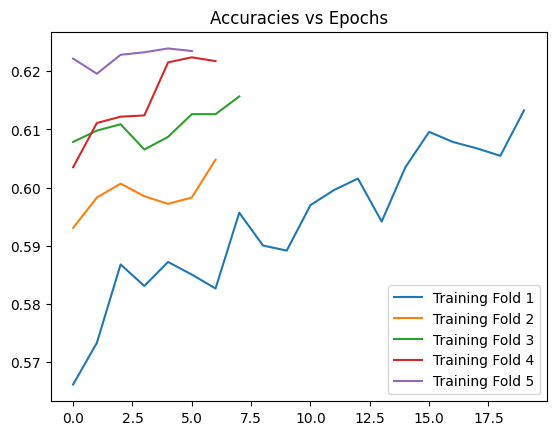

In [29]:
plt.title('Accuracies vs Epochs')
for i in range(len(model_history)):
  plt.plot(model_history[i].history['accuracy'], label=f"Training Fold {i+1}")

plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\Accuracy_vs_Epoch_VGG16.png')

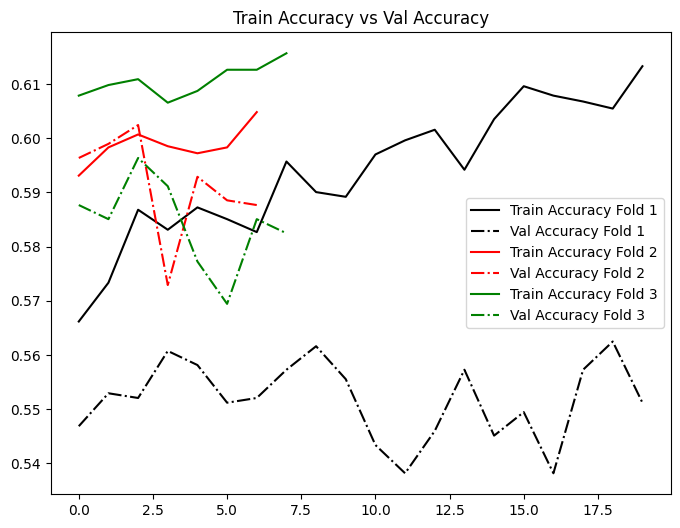

In [30]:
plt.figure(figsize=(8,6))
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.legend()
plt.show()
fig.savefig(r'D:\Users\RESA\Coding\Evaluasi\TrainAccuracy_vs_ValAccuracy_VGG16.png')

In [31]:
y_preds =  model.predict(X_test)
y_preds

array([[0.64913785, 0.18054217, 0.24427205, 0.39237034],
       [0.35942364, 0.49423638, 0.16476572, 0.33771408],
       [0.42791364, 0.62687373, 0.22129273, 0.3289165 ],
       ...,
       [0.28365532, 0.430126  , 0.5793007 , 0.17302057],
       [0.11096844, 0.23861843, 0.48456162, 0.6938032 ],
       [0.07553345, 0.5541443 , 0.6786481 , 0.45754662]], dtype=float32)

In [32]:
y_preds_arg = np.argmax(y_preds,axis=1)
y_preds_arg

array([0, 1, 1, ..., 2, 3, 2], dtype=int64)

In [33]:
asd = np.argmax(Y_test, axis=1)
asd

array([0, 3, 0, ..., 2, 3, 3], dtype=int64)

In [34]:
confusion_matrix(asd,y_preds_arg)

array([[238,  31,  61,  27],
       [ 63, 183,  86,  31],
       [ 34,  33, 263,  25],
       [ 57,  55,  86, 167]], dtype=int64)

In [35]:
print(classification_report(asd,y_preds_arg))

              precision    recall  f1-score   support

           0       0.61      0.67      0.64       357
           1       0.61      0.50      0.55       363
           2       0.53      0.74      0.62       355
           3       0.67      0.46      0.54       365

    accuracy                           0.59      1440
   macro avg       0.60      0.59      0.59      1440
weighted avg       0.60      0.59      0.59      1440



In [36]:
def draw_confusion_matrix(true,preds):
    conf_matx = confusion_matrix(true, preds)
    sns.heatmap(conf_matx, annot=True,fmt='g', cmap="viridis")
    plt.show()

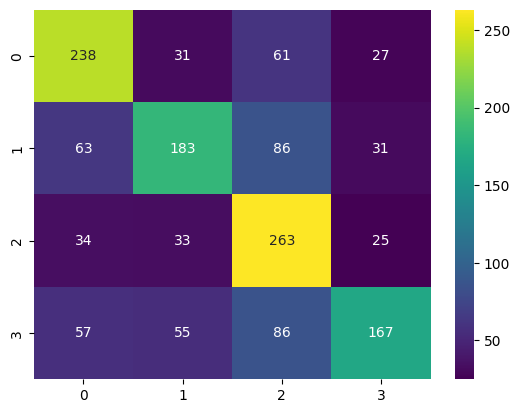

In [37]:
draw_confusion_matrix(asd,y_preds_arg)